## Importing Libraries

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

warnings.filterwarnings("ignore")

In [15]:
# ---------- Load metadata ----------
metadata = pd.read_csv("metadata.csv")
emotion_labels = metadata[['file_name', 'emotion']]

## SVM

### Helper Functions

In [16]:
# ---------- Helper Functions ----------

def load_and_prepare_features(file_path, label_df):
    """Load feature CSV and join with emotion labels from metadata"""
    df = pd.read_csv(file_path)
    df['file'] = df['file'].apply(lambda x: os.path.basename(str(x)))  # Normalize filename
    df = df.merge(label_df, left_on='file', right_on='file_name')

    # Drop non-feature columns
    feature_df = df.drop(columns=['file', 'file_name', 'emotion'])

    # Fill missing values in numeric columns only
    feature_df = feature_df.apply(pd.to_numeric, errors='coerce')  # Convert everything to numeric, ignore strings
    feature_df = feature_df.fillna(feature_df.mean())  # Fill remaining NaNs with column means

    X = feature_df.values
    y = df['emotion'].values
    return X, y

def encode_and_split(X, y):
    """Encode labels, scale features, split into train-test"""
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
    )
    return X_train, X_test, y_train, y_test, label_encoder

def train_svm(X_train, y_train):
    """Train SVM with GridSearchCV and return best model"""
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],
        'kernel': ['rbf']
    }
    grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best parameters:", grid_search.best_params_)
    return grid_search.best_estimator_

def evaluate_model(model, X_test, y_test, label_encoder, title="Confusion Matrix"):
    """Print report and plot confusion matrix"""
    y_pred = model.predict(X_test)
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    labels = label_encoder.classes_

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".1f", cmap="YlGnBu", xticklabels=labels, yticklabels=labels, linewidths=1)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def run_svm_pipeline(feature_file, title="SVM Model"):
    print(f"\n==== Running SVM for: {title} ====")
    X, y = load_and_prepare_features(feature_file, emotion_labels)
    X_train, X_test, y_train, y_test, label_encoder = encode_and_split(X, y)
    model = train_svm(X_train, y_train)
    evaluate_model(model, X_test, y_test, label_encoder, title=title)
    
    return model



### ---------- Run for All Feature Sets ----------


==== Running SVM for: MFCC Features ====
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

Classification Report:
               precision    recall  f1-score   support

       anger       0.87      1.00      0.93        26
     boredom       0.53      0.56      0.55        16
     disgust       0.86      0.67      0.75         9
        fear       0.92      0.86      0.89        14
   happiness       0.77      0.71      0.74        14
     neutral       0.60      0.56      0.58        16
     sadness       0.92      0.92      0.92        12

    accuracy                           0.78       107
   macro avg       0.78      0.75      0.76       107
weighted avg       0.78      0.78      0.77       107



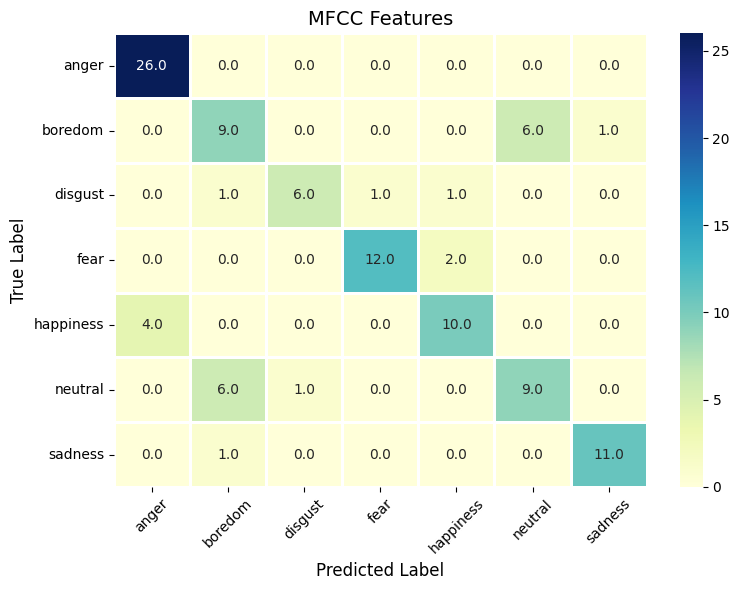

In [48]:
svm_mfcc = run_svm_pipeline("mfcc_features.csv", title="MFCC Features")


==== Running SVM for: Prosody Features - Word Level ====
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

Classification Report:
               precision    recall  f1-score   support

       anger       0.58      0.81      0.68        26
     boredom       0.52      0.69      0.59        16
     disgust       0.33      0.11      0.17         9
        fear       0.43      0.43      0.43        14
   happiness       0.75      0.21      0.33        14
     neutral       0.42      0.50      0.46        16
     sadness       0.70      0.58      0.64        12

    accuracy                           0.53       107
   macro avg       0.53      0.48      0.47       107
weighted avg       0.54      0.53      0.51       107



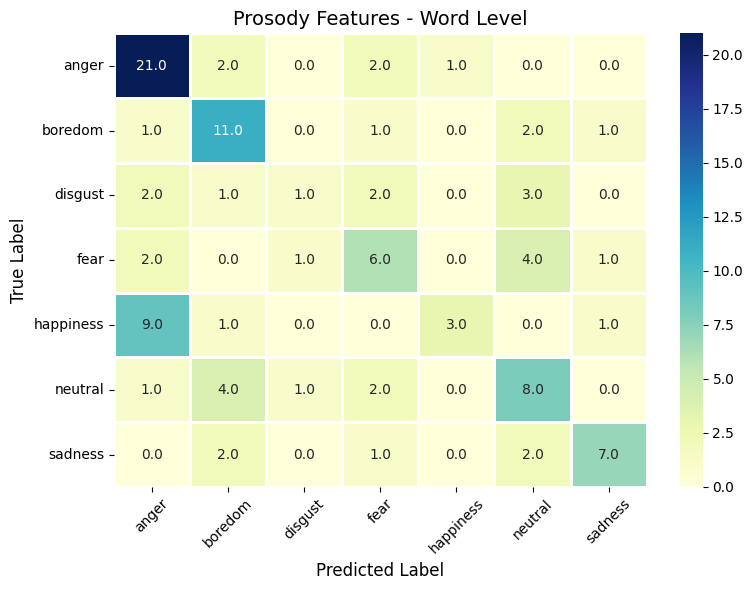

In [49]:
svm_word = run_svm_pipeline("prosody_word.csv", title="Prosody Features - Word Level")


==== Running SVM for: Prosody Features - Syllable Level ====
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

Classification Report:
               precision    recall  f1-score   support

       anger       0.54      0.85      0.66        26
     boredom       0.42      0.50      0.46        16
     disgust       0.00      0.00      0.00         9
        fear       0.33      0.21      0.26        14
   happiness       0.00      0.00      0.00        14
     neutral       0.28      0.44      0.34        16
     sadness       0.60      0.50      0.55        12

    accuracy                           0.43       107
   macro avg       0.31      0.36      0.32       107
weighted avg       0.35      0.43      0.37       107



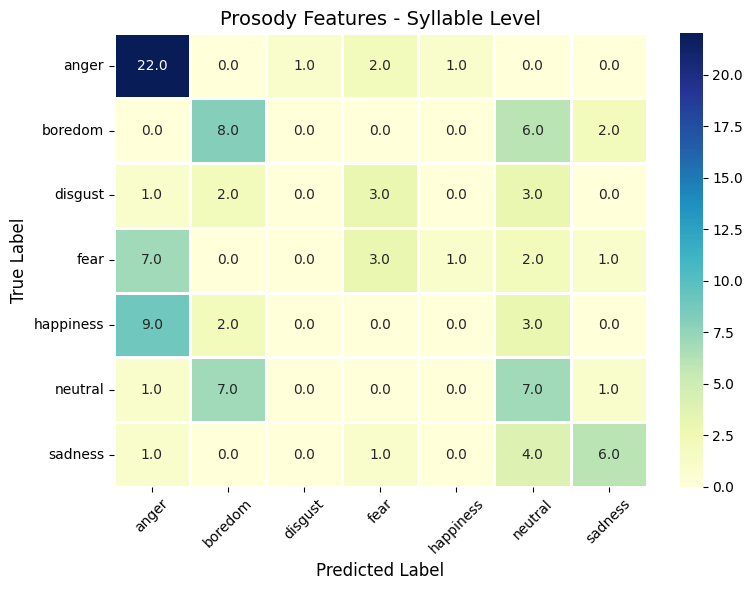

In [50]:
svm_syll = run_svm_pipeline("prosody_syllable.csv", title="Prosody Features - Syllable Level")


==== Running SVM for: Prosody Features - Utterance Level ====
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

Classification Report:
               precision    recall  f1-score   support

       anger       0.54      0.77      0.63        26
     boredom       0.40      0.50      0.44        16
     disgust       0.00      0.00      0.00         9
        fear       0.50      0.43      0.46        14
   happiness       0.33      0.07      0.12        14
     neutral       0.41      0.56      0.47        16
     sadness       0.64      0.58      0.61        12

    accuracy                           0.48       107
   macro avg       0.40      0.42      0.39       107
weighted avg       0.43      0.48      0.44       107



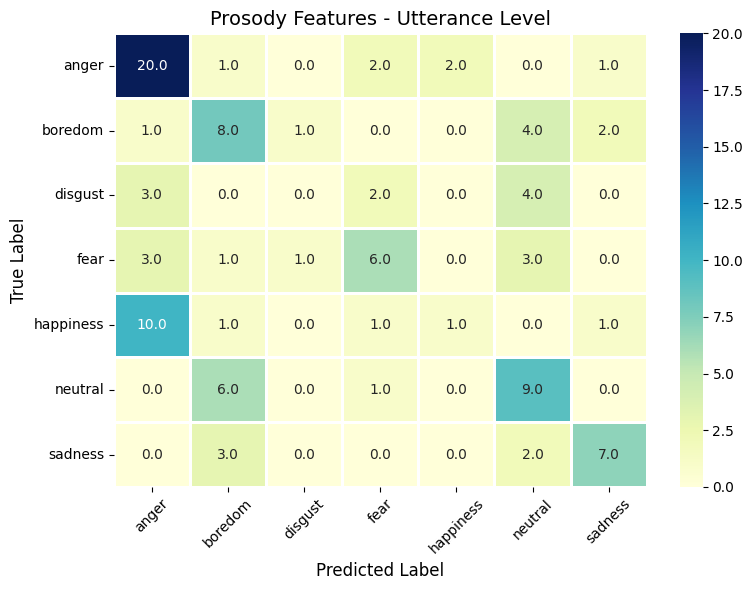

In [51]:
svm_utt = run_svm_pipeline("prosody_utterance.csv", title="Prosody Features - Utterance Level")

## GMM

In [21]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [22]:
def run_gmm_pipeline(feature_file, title="GMM Model"):
    print(f"\n==== Running GMM for: {title} ====")
    
    # Load and prepare data
    X, y = load_and_prepare_features(feature_file, emotion_labels)
    X_train, X_test, y_train, y_test, label_encoder = encode_and_split(X, y)

    # Define and train GMM
    num_classes = len(np.unique(y_train))
    gmm_model = GaussianMixture(n_components=num_classes, covariance_type='full', random_state=42)
    gmm_model.fit(X_train)

    # Predict using GMM
    y_pred = gmm_model.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("\nGMM Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    labels = label_encoder.classes_

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".1f", cmap="YlOrRd", xticklabels=labels, yticklabels=labels, linewidths=1)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return gmm_model  # Return trained model for reuse



==== Running GMM for: GMM - MFCC Features ====
Accuracy: 0.1495

GMM Classification Report:
               precision    recall  f1-score   support

       anger       0.09      0.04      0.05        26
     boredom       0.06      0.06      0.06        16
     disgust       0.14      0.22      0.17         9
        fear       0.00      0.00      0.00        14
   happiness       0.00      0.00      0.00        14
     neutral       0.00      0.00      0.00        16
     sadness       0.41      1.00      0.59        12

    accuracy                           0.15       107
   macro avg       0.10      0.19      0.12       107
weighted avg       0.09      0.15      0.10       107



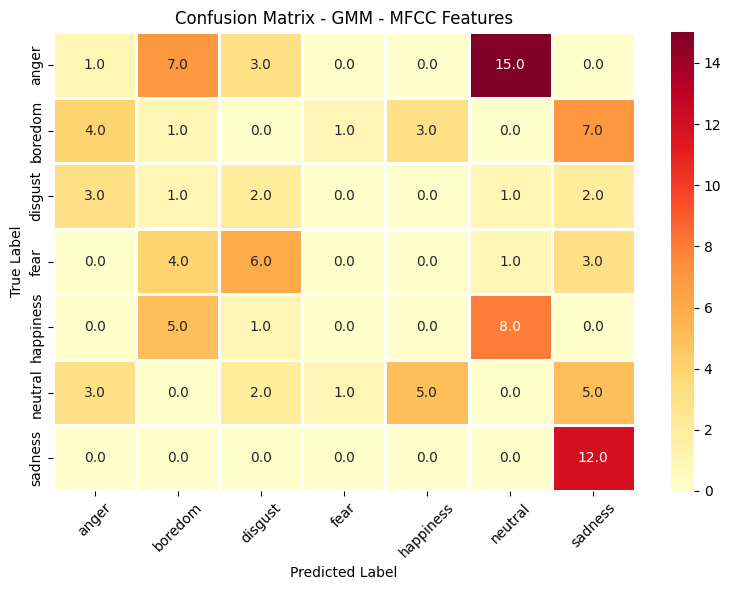

In [23]:
gmm_mfcc = run_gmm_pipeline("mfcc_features.csv", title="GMM - MFCC Features")


==== Running GMM for: GMM - Prosody Word Level ====
Accuracy: 0.1308

GMM Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        26
     boredom       0.14      0.56      0.23        16
     disgust       0.15      0.33      0.21         9
        fear       0.08      0.14      0.11        14
   happiness       0.00      0.00      0.00        14
     neutral       0.00      0.00      0.00        16
     sadness       0.00      0.00      0.00        12

    accuracy                           0.13       107
   macro avg       0.05      0.15      0.08       107
weighted avg       0.04      0.13      0.07       107



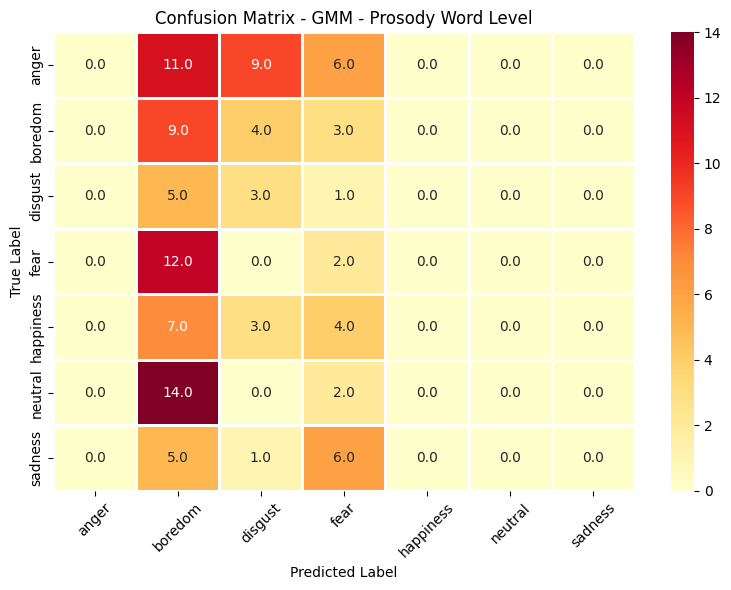

In [24]:
gmm_word = run_gmm_pipeline("prosody_word.csv", title="GMM - Prosody Word Level")


==== Running GMM for: GMM - Prosody Syllable Level ====
Accuracy: 0.1776

GMM Classification Report:
               precision    recall  f1-score   support

       anger       0.43      0.12      0.18        26
     boredom       0.21      0.94      0.35        16
     disgust       0.50      0.11      0.18         9
        fear       0.00      0.00      0.00        14
   happiness       0.00      0.00      0.00        14
     neutral       0.00      0.00      0.00        16
     sadness       0.00      0.00      0.00        12

    accuracy                           0.18       107
   macro avg       0.16      0.17      0.10       107
weighted avg       0.18      0.18      0.11       107



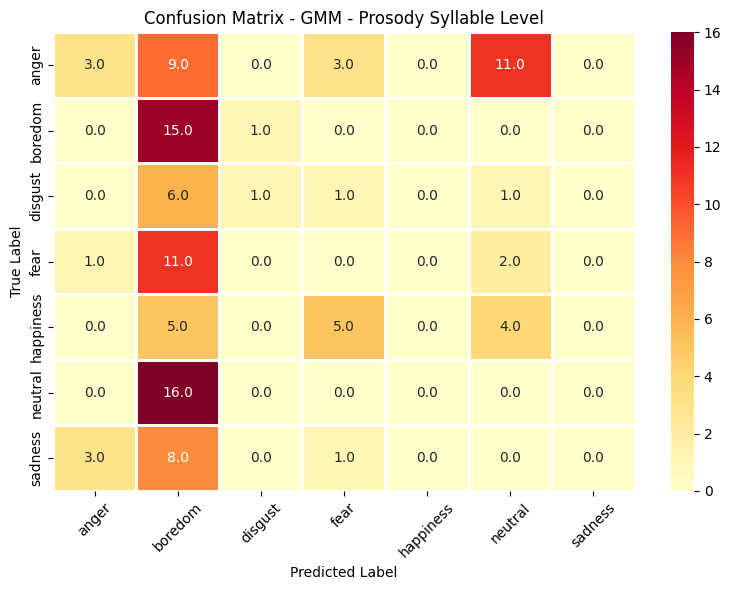

In [25]:
gmm_syll = run_gmm_pipeline("prosody_syllable.csv", title="GMM - Prosody Syllable Level")


==== Running GMM for: GMM - Prosody Utterance Level ====
Accuracy: 0.0654

GMM Classification Report:
               precision    recall  f1-score   support

       anger       0.00      0.00      0.00        26
     boredom       0.21      0.25      0.23        16
     disgust       0.11      0.11      0.11         9
        fear       0.13      0.14      0.14        14
   happiness       0.00      0.00      0.00        14
     neutral       0.00      0.00      0.00        16
     sadness       0.00      0.00      0.00        12

    accuracy                           0.07       107
   macro avg       0.06      0.07      0.07       107
weighted avg       0.06      0.07      0.06       107



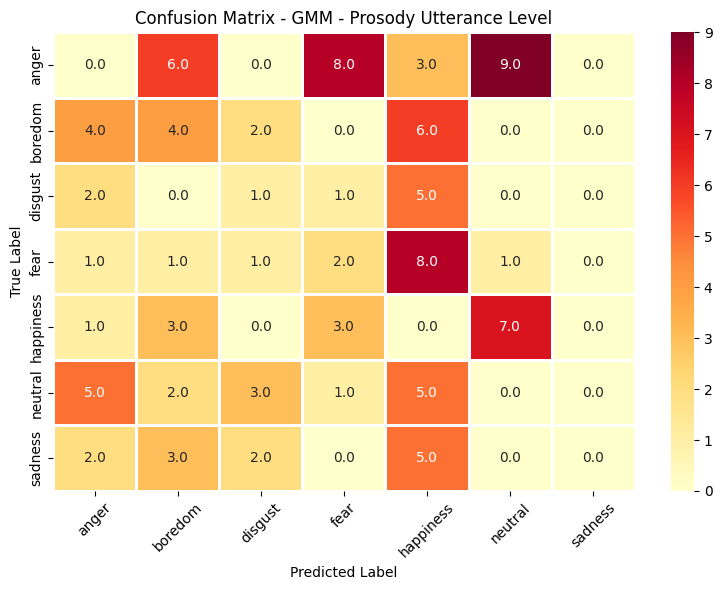

In [26]:
gmm_utt  = run_gmm_pipeline("prosody_utterance.csv", title="GMM - Prosody Utterance Level")

## MLP

In [27]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tqdm import tqdm
import tensorflow as tf


In [28]:
# ---------- tqdm Callback for training ----------
class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.pbar = tqdm(total=self.epochs, desc="Training MLP", unit="epoch")

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        self.pbar.set_postfix(acc=f"{logs['accuracy']:.4f}", val_acc=f"{logs['val_accuracy']:.4f}")

    def on_train_end(self, logs=None):
        self.pbar.close()


In [29]:
# ---------- MLP Pipeline ----------
def run_mlp_pipeline(feature_file, title="MLP Model"):
    print(f"\n==== Running MLP for: {title} ====")
    
    # Load and preprocess
    X, y = load_and_prepare_features(feature_file, emotion_labels)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # One-hot encode emotion labels
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    y_onehot = one_hot_encoder.fit_transform(y_encoded.reshape(-1, 1))

    # Scale and split
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, stratify=y_encoded, random_state=42)

    # Define MLP
    mlp_model = Sequential([
        Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(y_train.shape[1], activation='softmax')
    ])
    mlp_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train
    history = mlp_model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[TQDMProgressBar()],
        verbose=0
    )

    # Evaluate
    test_loss, test_acc = mlp_model.evaluate(X_test, y_test, verbose=0)
    print(f"\n✅ MLP Test Accuracy for {title}: {test_acc:.4f}")

    # Predictions & confusion matrix
    y_pred = mlp_model.predict(X_test).argmax(axis=1)
    y_true = y_test.argmax(axis=1)
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_true, y_pred)
    labels = label_encoder.classes_

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {title}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return mlp_model



==== Running MLP for: MLP - MFCC Features ====


Training MLP: 100%|██████████| 50/50 [00:07<00:00,  6.77epoch/s, acc=0.9836, val_acc=0.7477]



✅ MLP Test Accuracy for MLP - MFCC Features: 0.7477
4/4 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

       anger       0.68      0.96      0.79        26
     boredom       0.71      0.62      0.67        16
     disgust       0.83      0.56      0.67         9
        fear       0.86      0.86      0.86        14
   happiness       1.00      0.29      0.44        14
     neutral       0.71      0.75      0.73        16
     sadness       0.80      1.00      0.89        12

    accuracy                           0.75       107
   macro avg       0.80      0.72      0.72       107
weighted avg       0.78      0.75      0.73       107



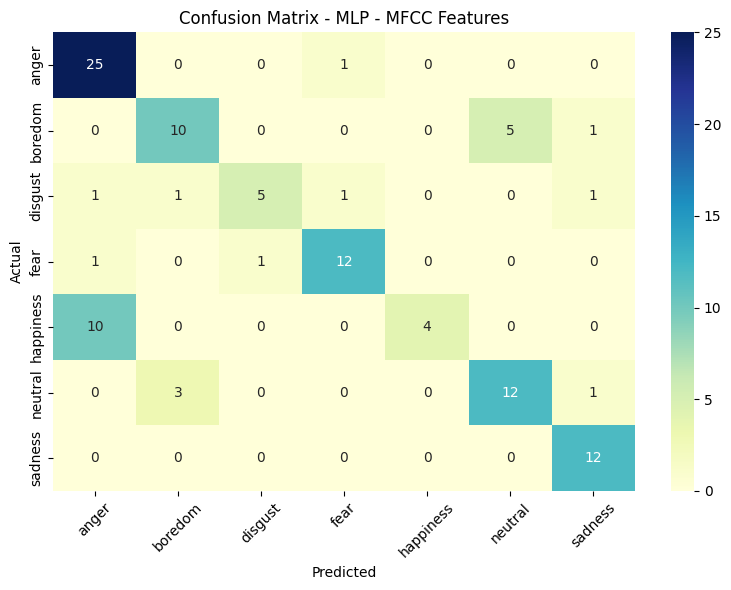

In [30]:
mlp_mfcc = run_mlp_pipeline("mfcc_features.csv", title="MLP - MFCC Features")


==== Running MLP for: MLP - Prosody Word Level ====


Training MLP: 100%|██████████| 50/50 [00:09<00:00,  5.43epoch/s, acc=0.8201, val_acc=0.5234]



✅ MLP Test Accuracy for MLP - Prosody Word Level: 0.5234
4/4 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

       anger       0.61      0.85      0.71        26
     boredom       0.48      0.62      0.54        16
     disgust       0.17      0.11      0.13         9
        fear       0.53      0.57      0.55        14
   happiness       0.50      0.07      0.12        14
     neutral       0.50      0.44      0.47        16
     sadness       0.54      0.58      0.56        12

    accuracy                           0.52       107
   macro avg       0.48      0.46      0.44       107
weighted avg       0.50      0.52      0.49       107



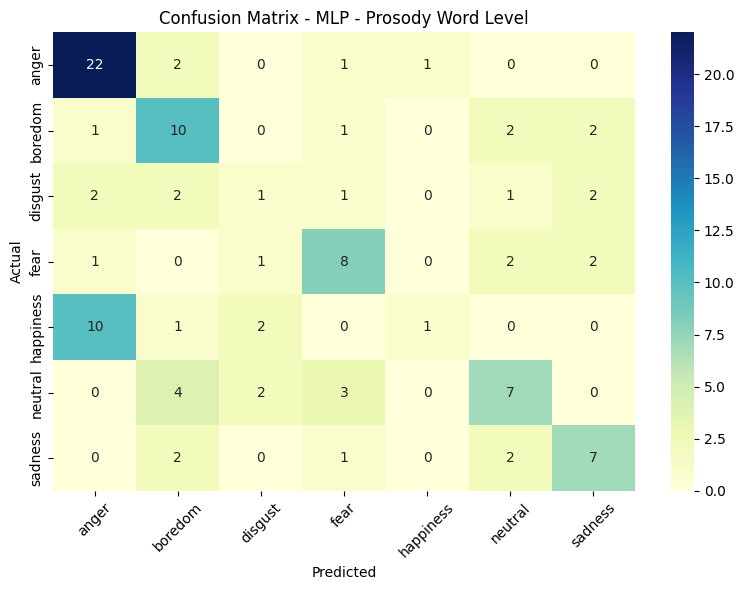

In [31]:
mlp_word = run_mlp_pipeline("prosody_word.csv", title="MLP - Prosody Word Level")


==== Running MLP for: MLP - Prosody Syllable Level ====


Training MLP: 100%|██████████| 50/50 [00:07<00:00,  7.14epoch/s, acc=0.9790, val_acc=0.3458]



✅ MLP Test Accuracy for MLP - Prosody Syllable Level: 0.3458
4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       anger       0.67      0.54      0.60        26
     boredom       0.22      0.12      0.16        16
     disgust       0.40      0.22      0.29         9
        fear       0.22      0.29      0.25        14
   happiness       0.08      0.07      0.08        14
     neutral       0.31      0.50      0.38        16
     sadness       0.38      0.50      0.43        12

    accuracy                           0.35       107
   macro avg       0.33      0.32      0.31       107
weighted avg       0.36      0.35      0.34       107



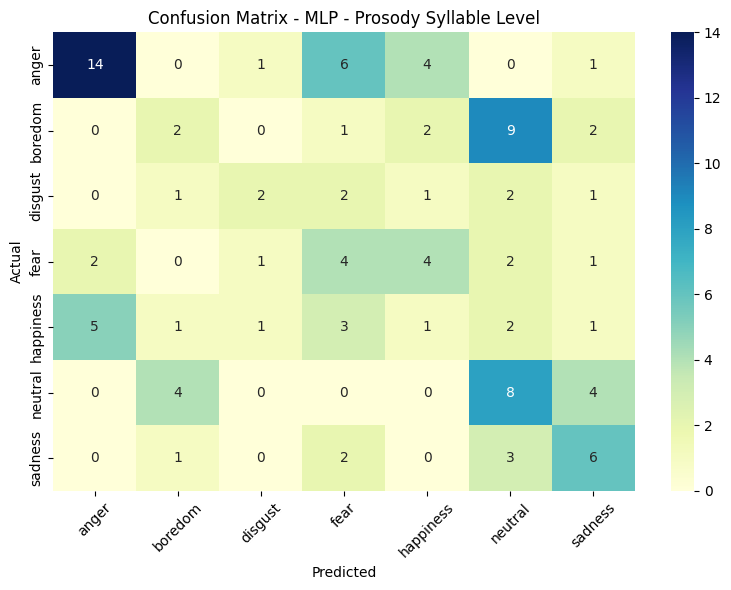

In [32]:
mlp_syll = run_mlp_pipeline("prosody_syllable.csv", title="MLP - Prosody Syllable Level")


==== Running MLP for: MLP - Prosody Utterance Level ====


Training MLP: 100%|██████████| 50/50 [00:06<00:00,  7.43epoch/s, acc=0.6145, val_acc=0.4766]



✅ MLP Test Accuracy for MLP - Prosody Utterance Level: 0.4766
4/4 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       anger       0.50      0.77      0.61        26
     boredom       0.42      0.31      0.36        16
     disgust       0.38      0.33      0.35         9
        fear       0.44      0.29      0.35        14
   happiness       0.00      0.00      0.00        14
     neutral       0.43      0.62      0.51        16
     sadness       0.64      0.75      0.69        12

    accuracy                           0.48       107
   macro avg       0.40      0.44      0.41       107
weighted avg       0.41      0.48      0.43       107



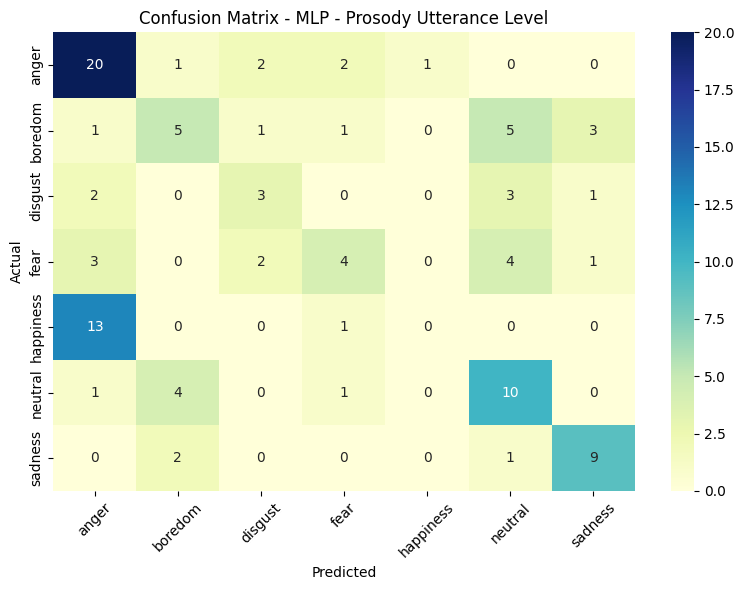

In [33]:
mlp_utt  = run_mlp_pipeline("prosody_utterance.csv", title="MLP - Prosody Utterance Level")

## XGBoost

In [34]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


### Helper Functions

In [35]:
def run_boosting_pipeline(feature_file, model_type='xgboost', title="Boosting Model"):
    print(f"\n==== Running {model_type.upper()} for: {title} ====")

    # Load & prepare
    X, y = load_and_prepare_features(feature_file, emotion_labels)
    X_train, X_test, y_train, y_test, label_encoder = encode_and_split(X, y)

    # Initialize model
    if model_type == 'xgboost':
        model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    elif model_type == 'lightgbm':
        model = LGBMClassifier(random_state=42)
    else:
        raise ValueError("Unsupported model type. Choose 'xgboost' or 'lightgbm'.")

    # Train
    model.fit(X_train, y_train)

    # Predict & evaluate
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n✅ {model_type.upper()} Accuracy for {title}: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    labels = label_encoder.classes_

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {title} ({model_type.upper()})")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return model


---------- XGBoost ----------



==== Running XGBOOST for: MFCC Features ====

✅ XGBOOST Accuracy for MFCC Features: 0.7009
              precision    recall  f1-score   support

       anger       0.74      0.88      0.81        26
     boredom       0.60      0.56      0.58        16
     disgust       0.83      0.56      0.67         9
        fear       0.82      0.64      0.72        14
   happiness       0.55      0.43      0.48        14
     neutral       0.71      0.75      0.73        16
     sadness       0.69      0.92      0.79        12

    accuracy                           0.70       107
   macro avg       0.70      0.68      0.68       107
weighted avg       0.70      0.70      0.69       107



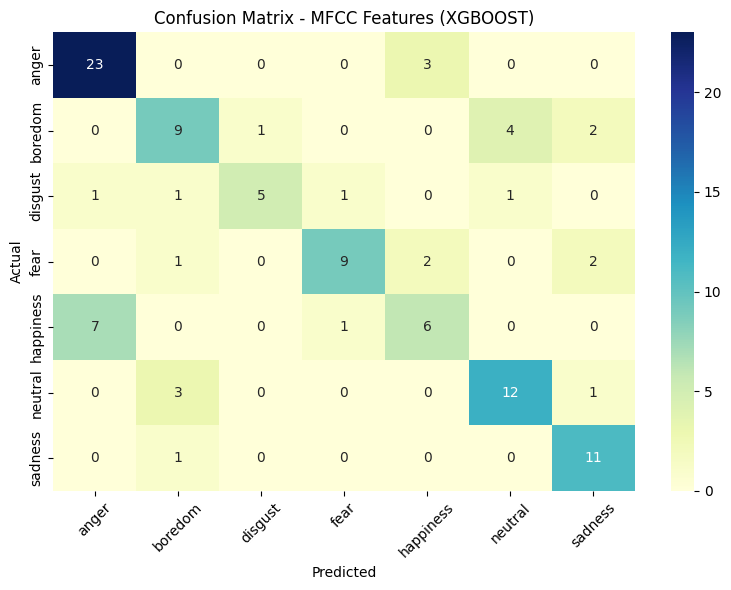

In [47]:
xgb_mfcc = run_boosting_pipeline("mfcc_features.csv", model_type='xgboost', title="MFCC Features")



==== Running XGBOOST for: Prosody Word Level ====

✅ XGBOOST Accuracy for Prosody Word Level: 0.5234
              precision    recall  f1-score   support

       anger       0.61      0.65      0.63        26
     boredom       0.50      0.62      0.56        16
     disgust       0.14      0.11      0.12         9
        fear       0.55      0.43      0.48        14
   happiness       0.45      0.36      0.40        14
     neutral       0.47      0.44      0.45        16
     sadness       0.67      0.83      0.74        12

    accuracy                           0.52       107
   macro avg       0.48      0.49      0.48       107
weighted avg       0.51      0.52      0.51       107



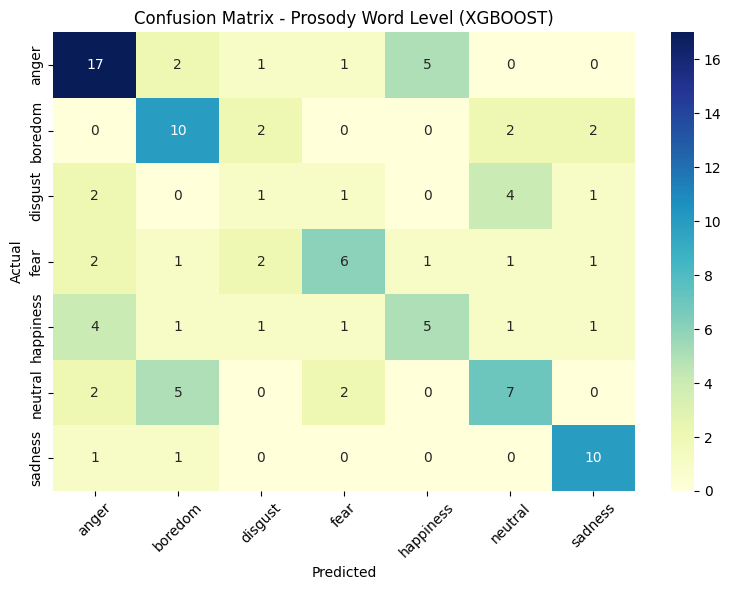

In [37]:
xgb_word = run_boosting_pipeline("prosody_word.csv", model_type='xgboost', title="Prosody Word Level")



==== Running XGBOOST for: Prosody Syllable Level ====

✅ XGBOOST Accuracy for Prosody Syllable Level: 0.4486
              precision    recall  f1-score   support

       anger       0.61      0.65      0.63        26
     boredom       0.37      0.44      0.40        16
     disgust       0.43      0.33      0.38         9
        fear       0.42      0.36      0.38        14
   happiness       0.38      0.21      0.27        14
     neutral       0.33      0.44      0.38        16
     sadness       0.50      0.50      0.50        12

    accuracy                           0.45       107
   macro avg       0.43      0.42      0.42       107
weighted avg       0.45      0.45      0.44       107



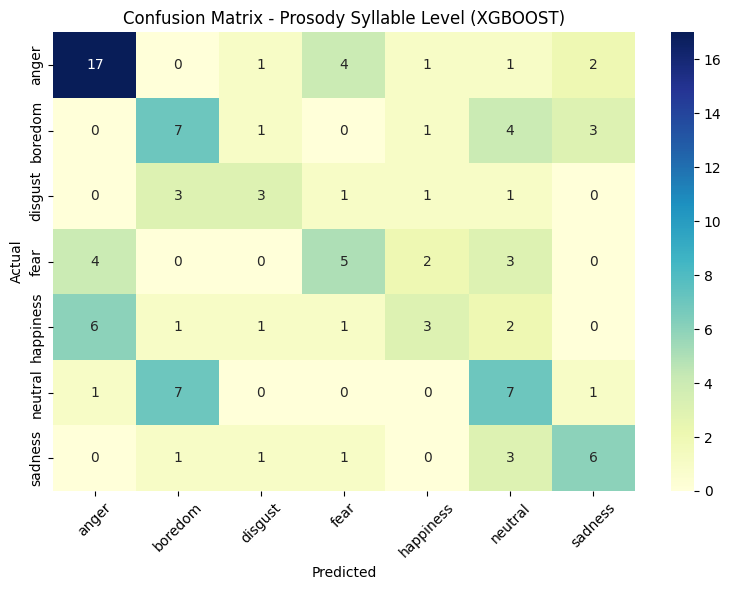

In [38]:
xgb_syll = run_boosting_pipeline("prosody_syllable.csv", model_type='xgboost', title="Prosody Syllable Level")



==== Running XGBOOST for: Prosody Utterance Level ====

✅ XGBOOST Accuracy for Prosody Utterance Level: 0.3645
              precision    recall  f1-score   support

       anger       0.39      0.50      0.44        26
     boredom       0.25      0.31      0.28        16
     disgust       0.14      0.11      0.12         9
        fear       0.50      0.29      0.36        14
   happiness       0.11      0.07      0.09        14
     neutral       0.38      0.38      0.38        16
     sadness       0.64      0.75      0.69        12

    accuracy                           0.36       107
   macro avg       0.35      0.34      0.34       107
weighted avg       0.35      0.36      0.35       107



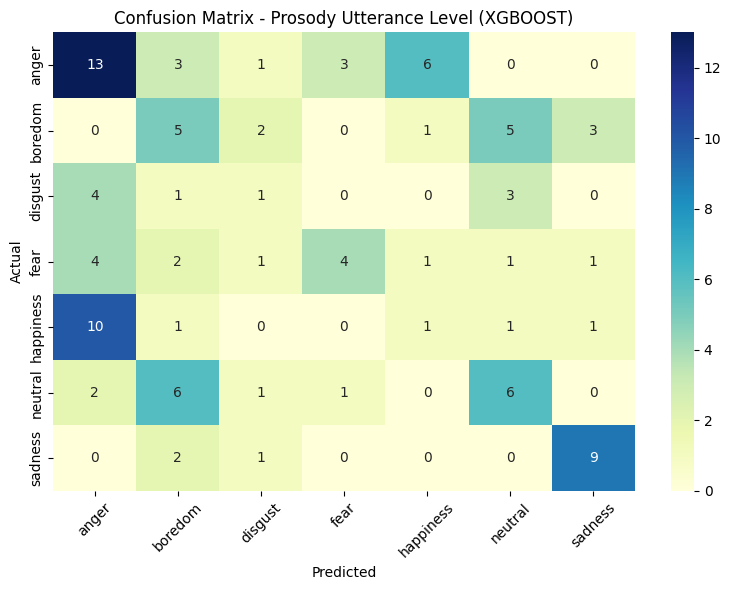

In [39]:
xgb_utt  = run_boosting_pipeline("prosody_utterance.csv", model_type='xgboost', title="Prosody Utterance Level")


---------- LightGBM ----------



==== Running LIGHTGBM for: MFCC Features ====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3718
[LightGBM] [Info] Number of data points in the train set: 428, number of used features: 26
[LightGBM] [Info] Start training from score -1.444003
[LightGBM] [Info] Start training from score -1.884736
[LightGBM] [Info] Start training from score -2.448205
[LightGBM] [Info] Start training from score -2.051790
[LightGBM] [Info] Start training from score -2.016072
[LightGBM] [Info] Start training from score -1.915988
[LightGBM] [Info] Start training from score -2.147100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

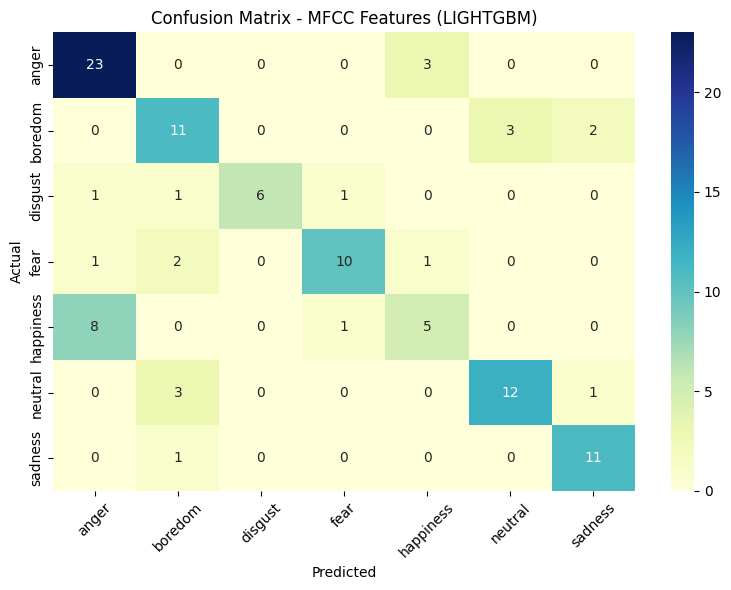

In [40]:
lgbm_mfcc = run_boosting_pipeline("mfcc_features.csv", model_type='lightgbm', title="MFCC Features")



==== Running LIGHTGBM for: Prosody Word Level ====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4004
[LightGBM] [Info] Number of data points in the train set: 428, number of used features: 28
[LightGBM] [Info] Start training from score -1.444003
[LightGBM] [Info] Start training from score -1.884736
[LightGBM] [Info] Start training from score -2.448205
[LightGBM] [Info] Start training from score -2.051790
[LightGBM] [Info] Start training from score -2.016072
[LightGBM] [Info] Start training from score -1.915988
[LightGBM] [Info] Start training from score -2.147100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

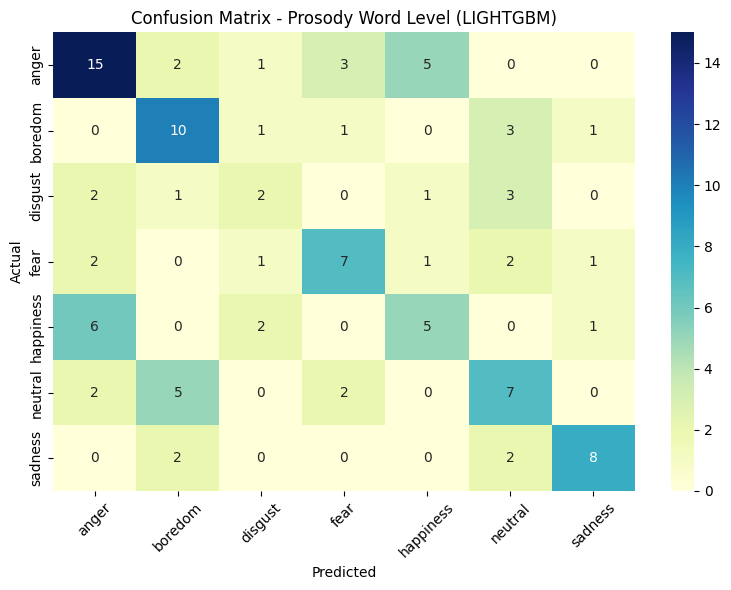

In [41]:
lgbm_word = run_boosting_pipeline("prosody_word.csv", model_type='lightgbm', title="Prosody Word Level")



==== Running LIGHTGBM for: Prosody Syllable Level ====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3363
[LightGBM] [Info] Number of data points in the train set: 428, number of used features: 30
[LightGBM] [Info] Start training from score -1.444003
[LightGBM] [Info] Start training from score -1.884736
[LightGBM] [Info] Start training from score -2.448205
[LightGBM] [Info] Start training from score -2.051790
[LightGBM] [Info] Start training from score -2.016072
[LightGBM] [Info] Start training from score -1.915988
[LightGBM] [Info] Start training from score -2.147100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

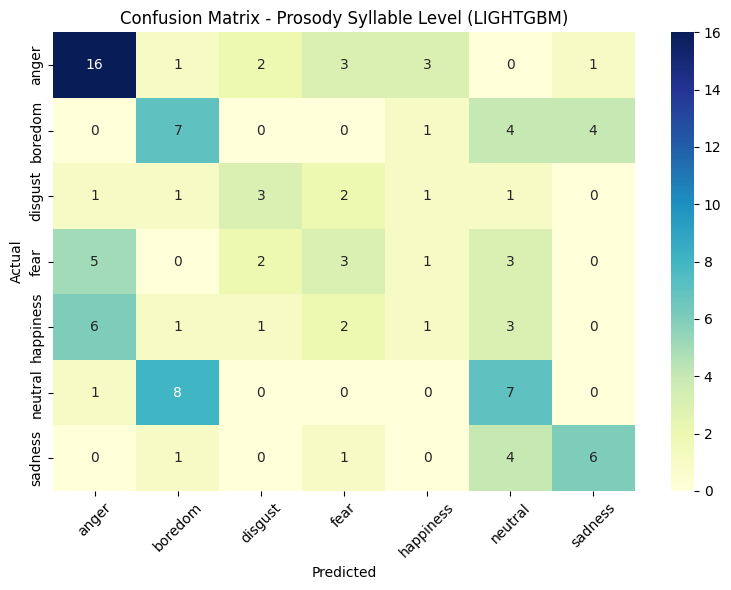

In [42]:
lgbm_syll = run_boosting_pipeline("prosody_syllable.csv", model_type='lightgbm', title="Prosody Syllable Level")



==== Running LIGHTGBM for: Prosody Utterance Level ====
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 428, number of used features: 4
[LightGBM] [Info] Start training from score -1.444003
[LightGBM] [Info] Start training from score -1.884736
[LightGBM] [Info] Start training from score -2.448205
[LightGBM] [Info] Start training from score -2.051790
[LightGBM] [Info] Start training from score -2.016072
[LightGBM] [Info] Start training from score -1.915988
[LightGBM] [Info] Start training from score -2.147100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

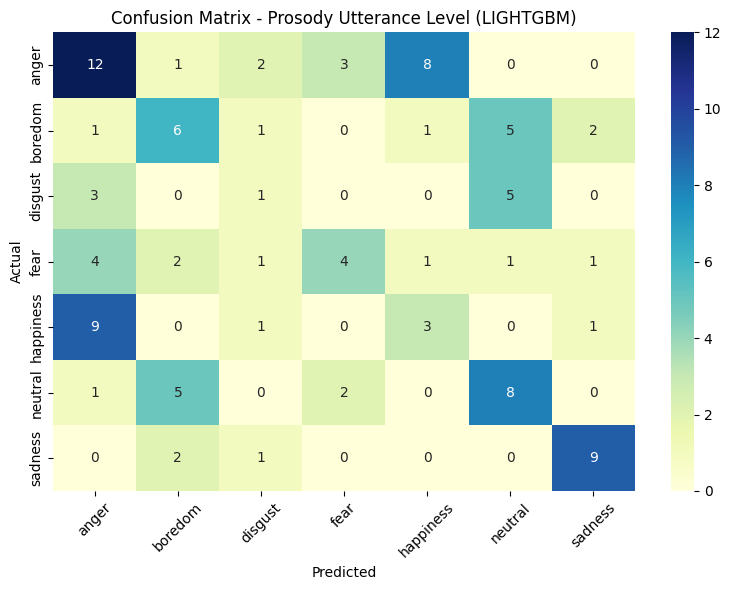

In [43]:

lgbm_utt  = run_boosting_pipeline("prosody_utterance.csv", model_type='lightgbm', title="Prosody Utterance Level")


## Ensemble Voting

### Create Aligned Prediction Files for Each Model

In [66]:
def get_predictions_df(model, feature_file, label_df, model_type='mlp', label_encoder=None):
    """Returns a DataFrame with file names and predicted labels"""
    X, y = load_and_prepare_features(feature_file, label_df)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Encode labels just for evaluation
    le = label_encoder or LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Predict
    if model_type == 'mlp':
        y_pred = model.predict(X_scaled).argmax(axis=1)
    else:
        y_pred = model.predict(X_scaled)

    filenames = pd.read_csv(feature_file)['file'].apply(lambda x: os.path.basename(str(x))).values
    return pd.DataFrame({'file': filenames, 'pred': y_pred}), le


### Level Wise ensemble functions

In [52]:
def ensemble_level(models, feature_file, label_df, model_types, label_encoder=None):
    """Ensemble multiple models trained on the same feature set"""
    preds_df = None
    for i, (model, m_type) in enumerate(zip(models, model_types)):
        df, le = get_predictions_df(model, feature_file, label_df, model_type=m_type, label_encoder=label_encoder)
        df.rename(columns={'pred': f'model_{i}'}, inplace=True)
        preds_df = df if preds_df is None else preds_df.merge(df, on='file')
        label_encoder = le  # preserve label encoder

    # Majority vote across models
    preds_df['voted'] = preds_df[[f'model_{i}' for i in range(len(models))]].mode(axis=1)[0]
    return preds_df[['file', 'voted']], label_encoder


In [54]:
ens_mfcc, le = ensemble_level(
    [svm_mfcc, mlp_mfcc, xgb_mfcc, lgbm_mfcc],
    "mfcc_features.csv",
    emotion_labels,
    model_types=['svm', 'mlp', 'xgboost', 'lightgbm']
)



17/17 [==============================] - 0s 2ms/step


In [55]:
ens_word, _ = ensemble_level(
    [svm_word, mlp_word, xgb_word, lgbm_word],
    "prosody_word.csv",
    emotion_labels,
    model_types=['svm', 'mlp', 'xgboost', 'lightgbm'],
    label_encoder=le
)



17/17 [==============================] - 0s 2ms/step


In [56]:
ens_syll, _ = ensemble_level(
    [svm_syll, mlp_syll, xgb_syll, lgbm_syll],
    "prosody_syllable.csv",
    emotion_labels,
    model_types=['svm', 'mlp', 'xgboost', 'lightgbm'],
    label_encoder=le
)

17/17 [==============================] - 0s 2ms/step


In [57]:
ens_utt, _ = ensemble_level(
    [svm_utt, mlp_utt, xgb_utt, lgbm_utt],
    "prosody_utterance.csv",
    emotion_labels,
    model_types=['svm', 'mlp', 'xgboost', 'lightgbm'],
    label_encoder=le
)


17/17 [==============================] - 0s 1ms/step


### Indivudual Accuracies

In [68]:
from sklearn.metrics import accuracy_score

def get_ensemble_accuracy(pred_df, label_encoder=None):
    """
    Compute accuracy of ensemble predictions against true labels.
    
    Parameters:
    - pred_df: DataFrame with columns ['file', 'voted']
    - label_encoder: Optional LabelEncoder to match label encoding (if needed)
    
    Returns:
    - accuracy: float
    """
    # Ensure filenames match
    ground_truth = emotion_labels.copy()
    ground_truth['file'] = ground_truth['file_name'].apply(lambda x: os.path.basename(x))
    
    merged = pred_df.merge(ground_truth[['file', 'emotion']], on='file')
    
    if label_encoder:
        y_true = label_encoder.transform(merged['emotion'])
    else:
        le = LabelEncoder()
        y_true = le.fit_transform(merged['emotion'])

    y_pred = merged['voted'].astype(int)

    return accuracy_score(y_true, y_pred)


In [69]:
acc_utt = get_ensemble_accuracy(ens_utt, label_encoder=le)
acc_word = get_ensemble_accuracy(ens_word, label_encoder=le)
acc_mfcc = get_ensemble_accuracy(ens_mfcc, label_encoder=le)
acc_syll = get_ensemble_accuracy(ens_syll, label_encoder=le)

print(f"Utterance Ensemble Accuracy: {acc_utt:.4f}")
print(f"Word-Level Ensemble Accuracy: {acc_word:.4f}")
print(f"MFCC Ensemble Accuracy: {acc_mfcc:.4f}")
print(f"Syllable-Level Ensemble Accuracy: {acc_syll:.4f}")


Utterance Ensemble Accuracy: 0.7570
Word-Level Ensemble Accuracy: 0.8542
MFCC Ensemble Accuracy: 0.9458
Syllable-Level Ensemble Accuracy: 0.8860


### Final Ensemble Output

🎯 Final Ensemble Accuracy: 0.8878504672897196
              precision    recall  f1-score   support

       anger       0.80      0.98      0.88       127
     boredom       0.84      0.95      0.89        81
     disgust       0.97      0.85      0.91        46
        fear       0.92      0.87      0.90        69
   happiness       1.00      0.68      0.81        71
     neutral       0.92      0.86      0.89        79
     sadness       0.97      0.95      0.96        62

    accuracy                           0.89       535
   macro avg       0.92      0.88      0.89       535
weighted avg       0.90      0.89      0.89       535



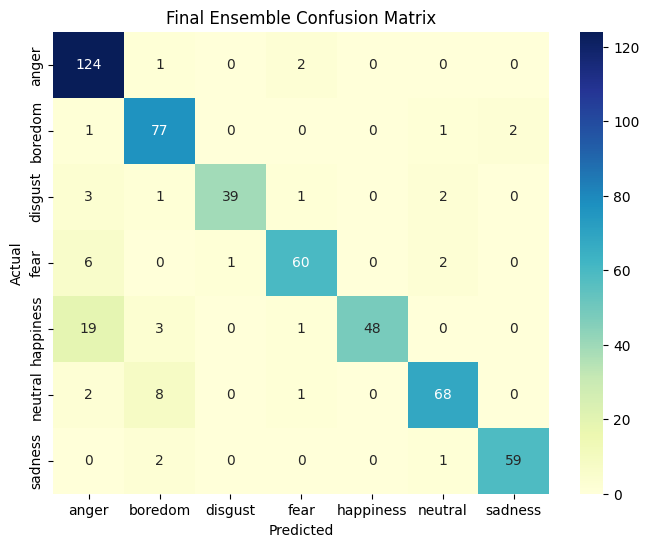

In [58]:
# Merge level-wise ensemble predictions
final_df = ens_mfcc.merge(ens_word, on='file', suffixes=('_mfcc', '_word')) \
                   .merge(ens_syll, on='file') \
                   .merge(ens_utt, on='file', suffixes=('_syll', '_utt'))
final_df.columns = ['file', 'mfcc', 'word', 'syll', 'utt']

# Final majority vote
final_df['final_vote'] = final_df[['mfcc', 'word', 'syll', 'utt']].mode(axis=1)[0]

# Merge true labels
truth = emotion_labels.copy()
truth['file'] = truth['file_name'].apply(lambda x: os.path.basename(x))
final_df = final_df.merge(truth[['file', 'emotion']], on='file')

# Evaluate
y_true = le.transform(final_df['emotion'])
y_pred = final_df['final_vote'].astype(int)

print("🎯 Final Ensemble Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Final Ensemble Confusion Matrix")
plt.show()


## Multi Branch NN 

In [59]:
def build_branch_model(input_dim, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


### Training Function

In [60]:
from tensorflow.keras.callbacks import Callback
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder

class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        self.pbar = tqdm(total=self.params['epochs'], desc="Training", unit="epoch")
    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        self.pbar.set_postfix(acc=f"{logs['accuracy']:.4f}", val_acc=f"{logs['val_accuracy']:.4f}")
    def on_train_end(self, logs=None):
        self.pbar.close()

In [61]:


def run_branch_model(feature_file, title):
    print(f"\n==== Training Branch for: {title} ====")
    X, y = load_and_prepare_features(feature_file, emotion_labels)

    # Label encoding
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    one_hot = OneHotEncoder(sparse_output=False)
    y_onehot = one_hot.fit_transform(y_encoded.reshape(-1, 1))

    # Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, stratify=y_encoded, random_state=42)

    # Build & train
    model = build_branch_model(X_train.shape[1], y_train.shape[1])
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                        callbacks=[TQDMProgressBar()], verbose=0)

    # Evaluate
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n✅ {title} - Accuracy: {test_acc:.4f}")

    # Classification report
    y_pred = model.predict(X_test).argmax(axis=1)
    y_true = y_test.argmax(axis=1)
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

    # Confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap="YlGnBu",
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return model



==== Training Branch for: MFCC Branch ====


Training: 100%|██████████| 50/50 [00:04<00:00, 10.62epoch/s, acc=0.9743, val_acc=0.7570]



✅ MFCC Branch - Accuracy: 0.7570
4/4 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       anger       0.78      0.96      0.86        26
     boredom       0.71      0.62      0.67        16
     disgust       0.75      0.33      0.46         9
        fear       0.85      0.79      0.81        14
   happiness       0.80      0.57      0.67        14
     neutral       0.63      0.75      0.69        16
     sadness       0.80      1.00      0.89        12

    accuracy                           0.76       107
   macro avg       0.76      0.72      0.72       107
weighted avg       0.76      0.76      0.74       107



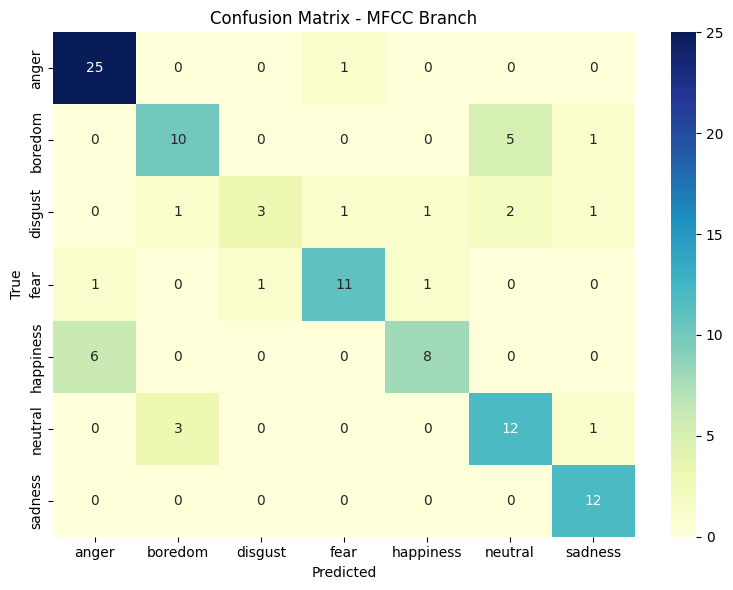

In [62]:
nn_mfcc = run_branch_model("mfcc_features.csv", title="MFCC Branch")



==== Training Branch for: Word-Level Prosody Branch ====


Training: 100%|██████████| 50/50 [00:04<00:00, 11.76epoch/s, acc=0.7430, val_acc=0.4953]



✅ Word-Level Prosody Branch - Accuracy: 0.4953
4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       anger       0.55      0.65      0.60        26
     boredom       0.52      0.69      0.59        16
     disgust       0.33      0.22      0.27         9
        fear       0.47      0.50      0.48        14
   happiness       0.40      0.14      0.21        14
     neutral       0.44      0.44      0.44        16
     sadness       0.54      0.58      0.56        12

    accuracy                           0.50       107
   macro avg       0.46      0.46      0.45       107
weighted avg       0.48      0.50      0.48       107



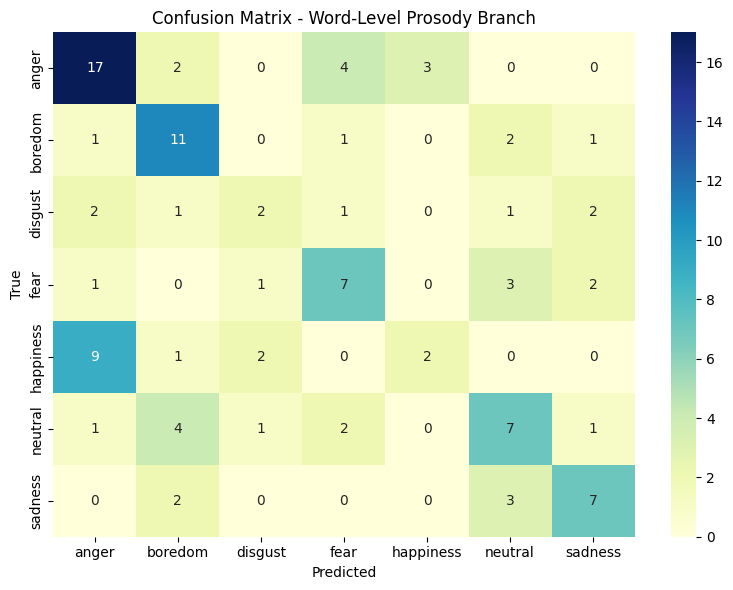

In [63]:
nn_word = run_branch_model("prosody_word.csv", title="Word-Level Prosody Branch")



==== Training Branch for: Syllable-Level Prosody Branch ====


Training: 100%|██████████| 50/50 [00:04<00:00, 12.28epoch/s, acc=0.9136, val_acc=0.4019]



✅ Syllable-Level Prosody Branch - Accuracy: 0.4019
4/4 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

       anger       0.70      0.62      0.65        26
     boredom       0.37      0.44      0.40        16
     disgust       0.27      0.33      0.30         9
        fear       0.23      0.21      0.22        14
   happiness       0.30      0.21      0.25        14
     neutral       0.32      0.38      0.34        16
     sadness       0.42      0.42      0.42        12

    accuracy                           0.40       107
   macro avg       0.37      0.37      0.37       107
weighted avg       0.41      0.40      0.40       107



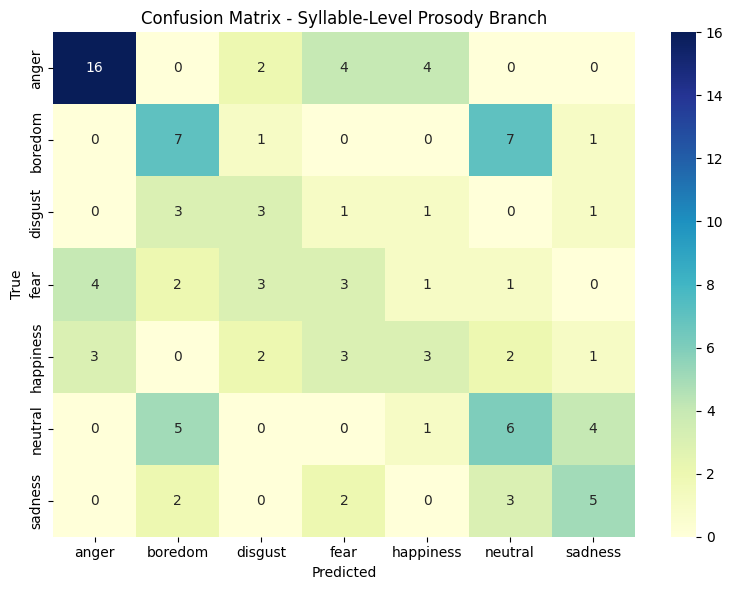

In [64]:
nn_syll = run_branch_model("prosody_syllable.csv", title="Syllable-Level Prosody Branch")



==== Training Branch for: Utterance-Level Prosody Branch ====


Training: 100%|██████████| 50/50 [00:04<00:00, 12.08epoch/s, acc=0.5981, val_acc=0.4860]



✅ Utterance-Level Prosody Branch - Accuracy: 0.4860
4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       anger       0.54      0.81      0.65        26
     boredom       0.47      0.44      0.45        16
     disgust       0.33      0.22      0.27         9
        fear       0.40      0.29      0.33        14
   happiness       0.50      0.07      0.12        14
     neutral       0.41      0.56      0.47        16
     sadness       0.62      0.67      0.64        12

    accuracy                           0.49       107
   macro avg       0.47      0.44      0.42       107
weighted avg       0.48      0.49      0.45       107



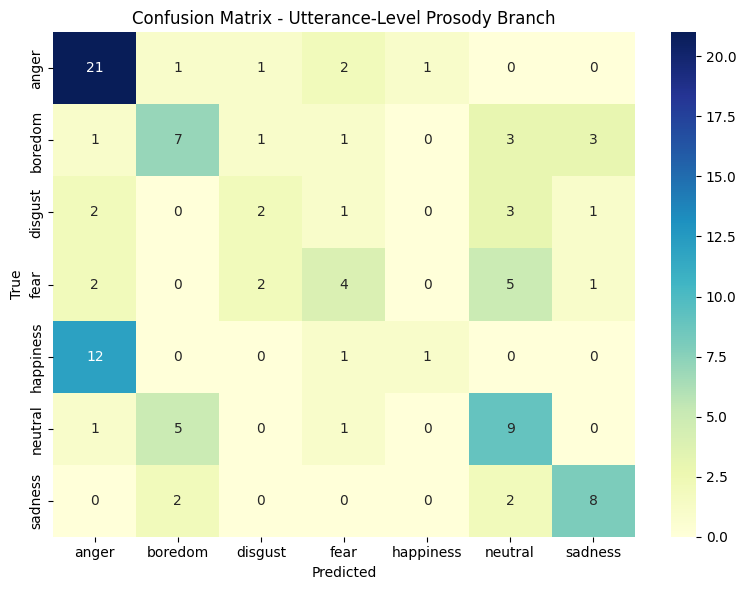

In [67]:
nn_utt  = run_branch_model("prosody_utterance.csv", title="Utterance-Level Prosody Branch")
